### kaggle タイタニック生存者
```
kaggle competitions download -c titanic
```

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## Common function

In [3]:
def plot_bar(x_df: pd.Series , y_df:pd.Series):
    if len(x_df.drop_duplicates()) > 100:
        return
    col_name  : str = x_df.name
    if len(x_df.drop_duplicates()) >30:
        plt.figure(figsize=(60 , 10))
    else:
        plt.figure(figsize=(10,5))
    sns.barplot(x=x_df.sort_values() , y=y_df )
    plt.title(f"Survied Rate by {col_name}")
    plt.show()    



### データの読み込み

In [4]:

train_df = pd.read_csv("input/train.csv")
test_df = pd.read_csv("input/test.csv")
train_df.info()
# sns.barplot(x=train_df["Sex"] , y=train_df["Survived"] )
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


----------------------------


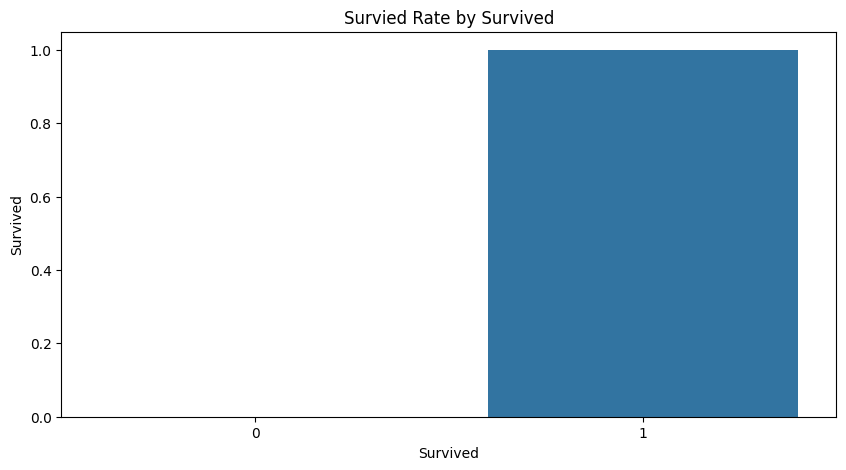

----------------------------


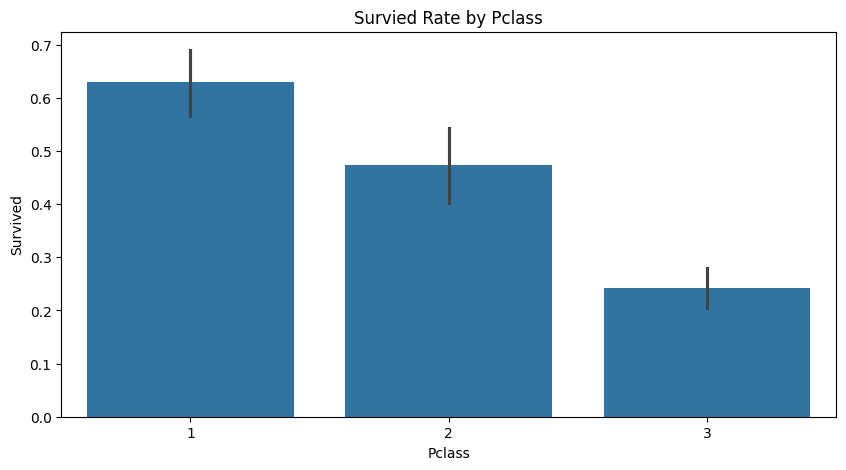

----------------------------


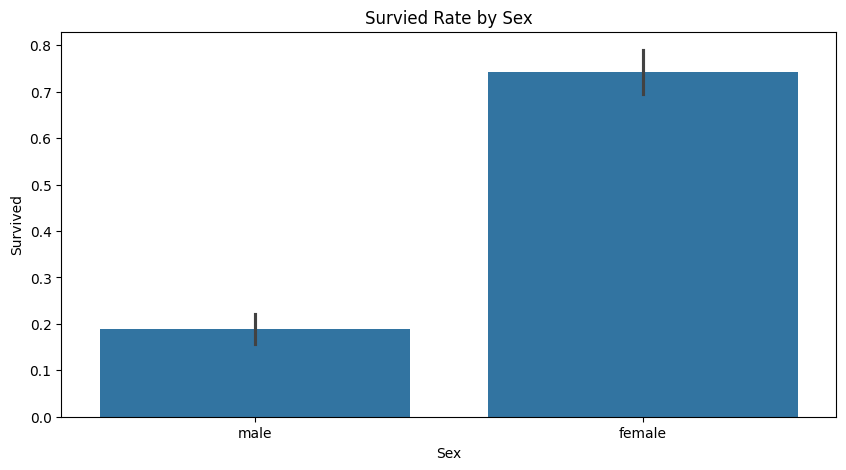

----------------------------


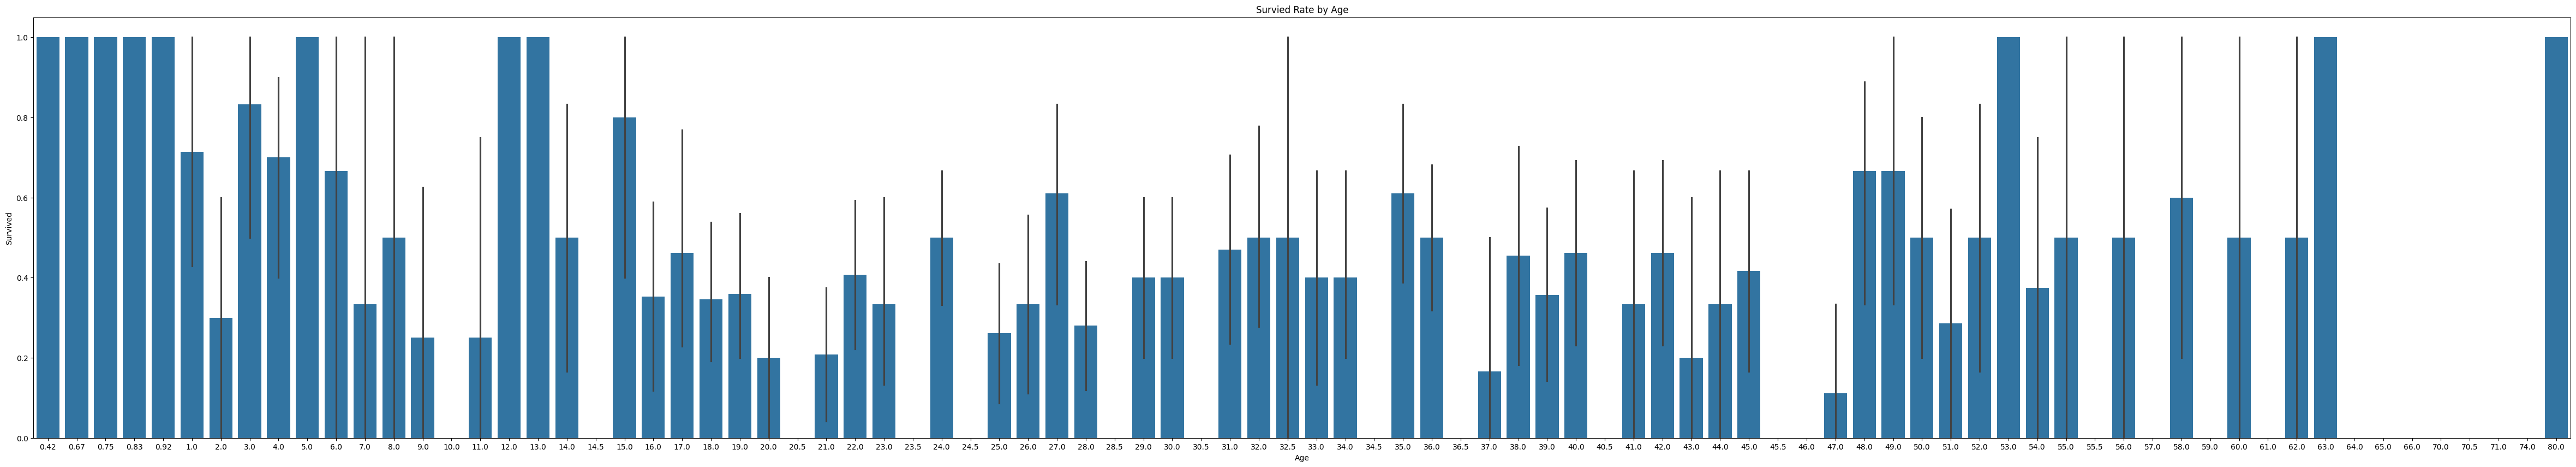

----------------------------


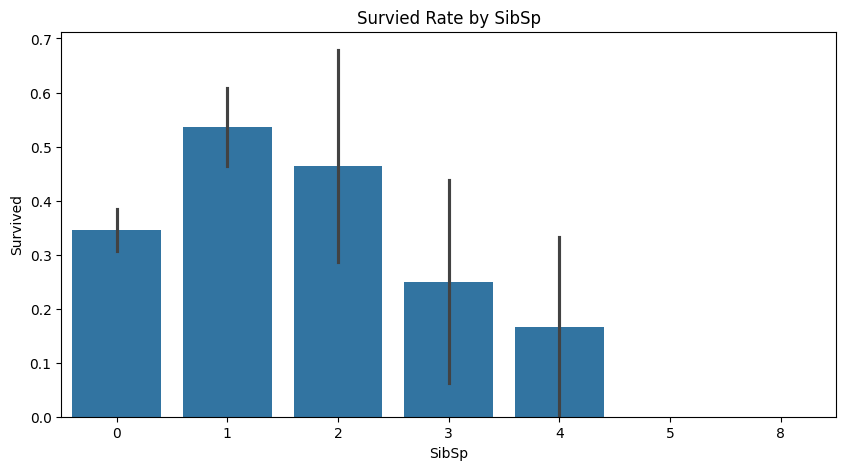

----------------------------


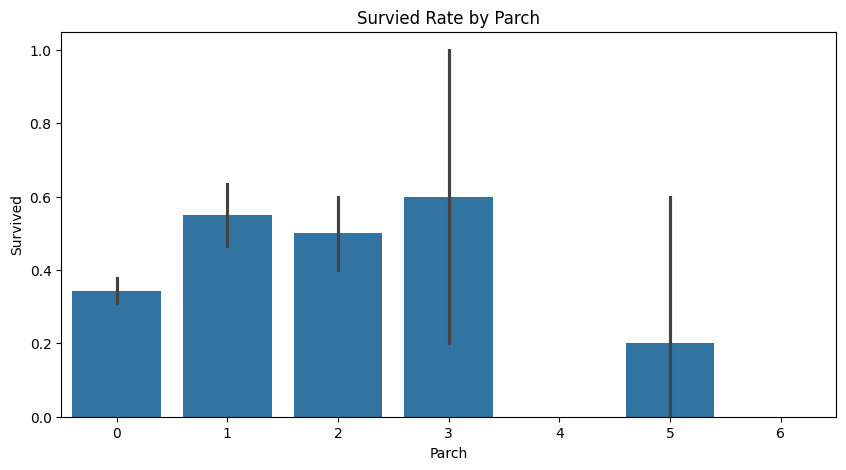

----------------------------


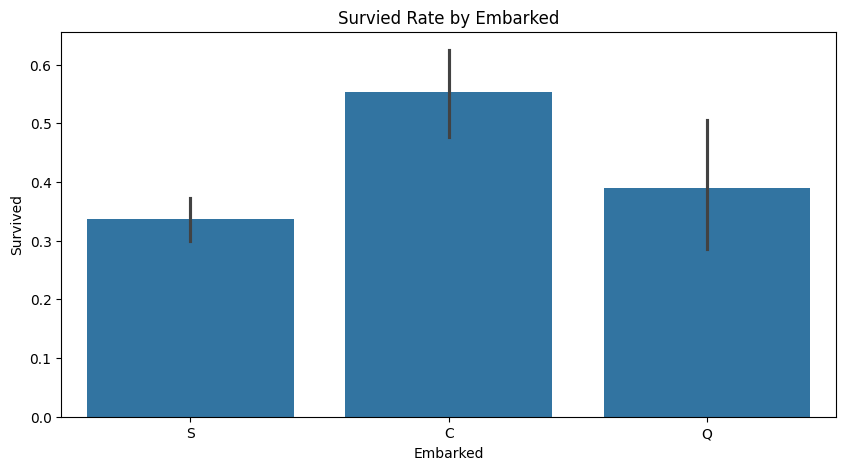

In [5]:
# train_df.value_counts()

all_col_map = {}
target_col_map = {}
dummie_col_list = []
train_cols_list : list = train_df.columns.to_list()
for col in train_cols_list:
    if len(train_df[col].drop_duplicates()) > 100:
        continue
    print("----------------------------")
    plot_bar(x_df=train_df[col] , y_df=train_df["Survived"])
    dummie_col_list.append(col)



### 年齢だけは相関が把握しきれていないので、分布図に起こす

In [6]:
def create_age_group_dummy(df : pd.DataFrame) -> pd.DataFrame:
    INTERVAL_BIN = 5

    max_age : int = df["Age"].max().astype(int)
    min_age : int = df["Age"].min().astype(int)
    bins : list = [num for num in range(min_age , max_age  + INTERVAL_BIN , INTERVAL_BIN)]
    labels : list = [f"{bins[i]}-{bins[i + 1]}" for i in range(len(bins) -1)]
    df["Age_Group"]  = pd.cut(df["Age"] , bins=bins , labels=labels , right=False)

    # plot_bar(df["Age_Group"] , df["Survived"])
    age_group_mode : str = df["Age_Group"].mode().values[0]
    df["Age_Group"] = df["Age_Group"].fillna(age_group_mode)

    ## この結果をもとに年齢区間のdummy変数を作成する
    age_dummies = pd.get_dummies(df["Age_Group"] , prefix="Age" , dtype=int)
    return age_dummies


In [7]:
excluede_dummies = [
    "Survived" ,
    "Age",
    # "Embarked",
    ]
new_dummie_col_list = [col for col in dummie_col_list if col not in excluede_dummies]
new_dummie_col_list

['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

## ほかカラムの前処理

In [8]:
def pre_exec(df : pd.DataFrame) -> pd.DataFrame:
    # train_df["Cabin"] = train_df["Cabin"].fillna("")
    df["Embarked"] = df["Embarked"].fillna(
        df["Embarked"].mode().values[0]
    )
    new_df = df[new_dummie_col_list].copy()
    new_df.info()
    return new_df
    

## ダミー処理

In [9]:
def create_dummy_df(df : pd.DataFrame ) -> pd.DataFrame:
    age_dummies : pd.DataFrame = create_age_group_dummy(df)
    df = pre_exec(df)
    for col in ["Pclass" , "Parch" , "SibSp"]:    
        df[col] = df[col].astype("category")
    x = pd.get_dummies(df,
                    drop_first=True,
                    dtype=int)
    x = pd.concat([x , age_dummies] , axis=1)
    x.insert(0 , 'intercept' , 1)
    return x

In [16]:
# train_df

x = create_dummy_df(train_df)
x.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Pclass    891 non-null    int64 
 1   Sex       891 non-null    object
 2   SibSp     891 non-null    int64 
 3   Parch     891 non-null    int64 
 4   Embarked  891 non-null    object
dtypes: int64(3), object(2)
memory usage: 34.9+ KB


['intercept',
 'Pclass_2',
 'Pclass_3',
 'Sex_male',
 'SibSp_1',
 'SibSp_2',
 'SibSp_3',
 'SibSp_4',
 'SibSp_5',
 'SibSp_8',
 'Parch_1',
 'Parch_2',
 'Parch_3',
 'Parch_4',
 'Parch_5',
 'Parch_6',
 'Embarked_Q',
 'Embarked_S',
 'Age_0-5',
 'Age_5-10',
 'Age_10-15',
 'Age_15-20',
 'Age_20-25',
 'Age_25-30',
 'Age_30-35',
 'Age_35-40',
 'Age_40-45',
 'Age_45-50',
 'Age_50-55',
 'Age_55-60',
 'Age_60-65',
 'Age_65-70',
 'Age_70-75',
 'Age_75-80']

## モデルのフィッティング

In [11]:
# モデルのフィッティング
md = sm.OLS(train_df["Survived"] , x)
model = md.fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     20.85
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           6.28e-84
Time:                        00:19:02   Log-Likelihood:                -371.99
No. Observations:                 891   AIC:                             808.0
Df Residuals:                     859   BIC:                             961.3
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9036      0.042     21.588      0.0

## 予測を行うテストデータの前処理

In [15]:
test_dummy_df = create_dummy_df(test_df)
test_dummy_df.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Pclass    418 non-null    int64 
 1   Sex       418 non-null    object
 2   SibSp     418 non-null    int64 
 3   Parch     418 non-null    int64 
 4   Embarked  418 non-null    object
dtypes: int64(3), object(2)
memory usage: 16.5+ KB


['intercept',
 'Pclass_2',
 'Pclass_3',
 'Sex_male',
 'SibSp_1',
 'SibSp_2',
 'SibSp_3',
 'SibSp_4',
 'SibSp_5',
 'SibSp_8',
 'Parch_1',
 'Parch_2',
 'Parch_3',
 'Parch_4',
 'Parch_5',
 'Parch_6',
 'Parch_9',
 'Embarked_Q',
 'Embarked_S',
 'Age_0-5',
 'Age_5-10',
 'Age_10-15',
 'Age_15-20',
 'Age_20-25',
 'Age_25-30',
 'Age_30-35',
 'Age_35-40',
 'Age_40-45',
 'Age_45-50',
 'Age_50-55',
 'Age_55-60',
 'Age_60-65',
 'Age_65-70',
 'Age_70-75',
 'Age_75-80']

In [13]:

predict_values = model.predict(test_dummy_df)
predict_values
# # しきい値を 0.5 に設定し、0 or 1 に変換
# predict_binary = (predict_values >= 0.5).astype(int)

# merge_df = pd.concat([test_df["PassengerId"] , predict_binary]  , axis=1)
# merge_df = merge_df.rename(columns={0 : "Survived"})
# merge_df.sort_values(by="PassengerId")


# os.makedirs("./out" , exist_ok=True)

# merge_df.to_csv("./out/result.csv", index=False)
# merge_df


ValueError: shapes (418,35) and (34,) not aligned: 35 (dim 1) != 34 (dim 0)